<a href="https://colab.research.google.com/github/yamada-github-account/LearnBayesNN/blob/master/BayesNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
 
import tensorflow as tf
import tensorflow_probability as tfp
 
import matplotlib.pyplot as plt
import numpy as np
 
from tqdm.notebook import tqdm
%matplotlib inline
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

In [2]:
def create_model(units,cls,**kwargs):
    return tf.keras.Sequential([cls(units[0],activation=tf.nn.leaky_relu,input_shape=(1,),**kwargs)] +
                               [cls(i,activation=tf.nn.leaky_relu,**kwargs) for i in units[1:-1]] +
                               [cls(units[-1],**kwargs)])
 
 
def weight_multivariate_normal_fn(weight):
    def _fn(dtype, shape, name, trainable,add_variable_fn):
        del name, trainable, add_variable_fn   # unused
        w = tf.convert_to_tensor(weight, dtype=dtype)
        dist = tfp.distributions.Normal(loc=w, scale=tf.math.abs(w) * 0.01)
        batch_ndims = tf.size(dist.batch_shape_tensor())
        return tfp.distributions.Independent(dist, reinterpreted_batch_ndims=batch_ndims)
    return _fn
 
def BNN_from_NN(NN,cls,default_params,**kwargs):
    if default_params:
        return create_model([L.units for L in NN.layers],cls,**kwargs)
    else:
        return tf.keras.Sequential([cls(NN.layers[0].units,
                                        activation=tf.nn.leaky_relu,
                                        input_shape=(tf.shape(NN.layers[0].kernel)[0],),
                                        kernel_prior_fn=weight_multivariate_normal_fn(NN.layers[0].kernel),
                                        bias_prior_fn=weight_multivariate_normal_fn(NN.layers[0].bias),
                                        **kwargs)] +
                                   [cls(L.units,
                                        activation=tf.nn.leaky_relu,
                                        kernel_prior_fn=weight_multivariate_normal_fn(L.kernel),
                                        bias_prior_fn=weight_multivariate_normal_fn(L.bias),
                                        **kwargs) for L in NN.layers[1:-1]] +
                                [cls(NN.layers[-1].units,
                                        kernel_prior_fn=weight_multivariate_normal_fn(NN.layers[-1].kernel),
                                        bias_prior_fn=weight_multivariate_normal_fn(NN.layers[-1].bias),
                                        **kwargs)])
 
 
units = [10,10,10,10,1]
tfp_kwargs = {"kernel_posterior_fn": tfp.layers.util.default_mean_field_normal_fn(untransformed_scale_initializer=tf.compat.v1.initializers.random_normal(mean=-0.5, stddev=0.01)),
              "bias_posterior_fn": tfp.layers.util.default_mean_field_normal_fn(untransformed_scale_initializer=tf.compat.v1.initializers.random_normal(mean=-0.5, stddev=0.01))}

In [3]:
# ベースライン
m0 = create_model(units,tf.keras.layers.Dense)

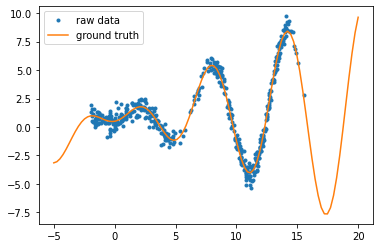

In [4]:
a = 0.5
b = 0.2
c = 0.5
d = -0.01
 
sigma = 0.5
epochs_base = 2000
epochs = 4000
 
 
def ground_truth(x):
    return a + b * x + c * x * np.sin(x) + d*x*x
 
data_x = np.concatenate([np.random.uniform(-2,5,200),np.random.normal(10,2,200),np.random.normal(13,1,100)])
data_y = ground_truth(data_x) + np.random.normal(0,sigma,data_x.shape)
plt.plot(data_x,data_y,linestyle="",marker=".",label="raw data")
 
x_ = np.linspace(-5,20,100)
plt.plot(x_,ground_truth(x_),label="ground truth")
plt.legend()
plt.show()
 
 
data_i = np.arange(data_x.shape[0])

In [5]:
m0.compile(loss="MeanSquaredError")

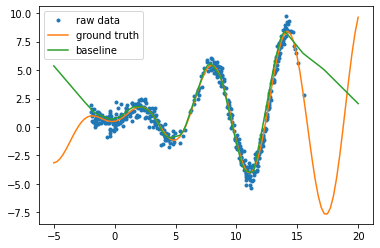

In [6]:
m0.fit(x=data_x,y=data_y,epochs=epochs_base,verbose=0)
 
plt.plot(data_x,data_y,linestyle="",marker=".",label="raw data")
plt.plot(x_,ground_truth(x_),label="ground truth")
 
plt.plot(x_,m0(x_),label="baseline")
plt.legend()

In [7]:
default = False
 
# 再パラメータ化勾配
m = BNN_from_NN(m0,tfp.layers.DenseReparameterization,default_params=default,**tfp_kwargs)
 
 
# ローカル再パラメータ化勾配
# m = BNN_from_NN(m0,tfp.layers.DenseLocalReparameterization,default_params=default,**tfp_kwargs)
 
 
# Flipout
# m = BNN_from_NN(m0,tfp.layers.DenseFlipout,default_params=default,**tfp_kwargs)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [13]:
def loss(model,x,y,epoch,n,writer):
    def fn():
        y_ = model(x)
 
        neg_log_prob = -tf.reduce_mean(tfp.distributions.Normal(loc=y_,scale=sigma).log_prob(y))
        kl =  sum(model.losses) / n
        _loss = neg_log_prob + kl
        with writer.as_default():
            name = model.layers[0].name
            tf.summary.scalar(f"{name}:-log(p(y|x,W))", neg_log_prob, step=epoch)
            tf.summary.scalar(f"{name}: KL divergence", kl          , step=epoch)
            tf.summary.scalar(f"{name}: Loss"         , _loss       , step=epoch)
        return _loss
    return fn

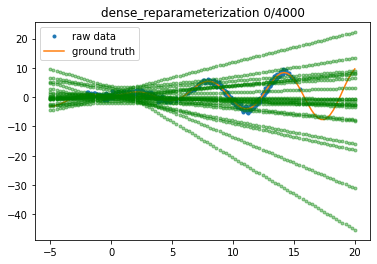

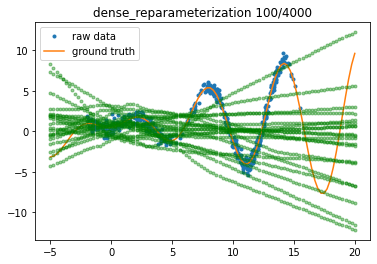

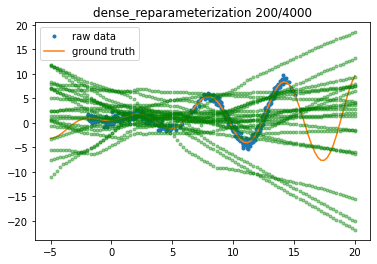

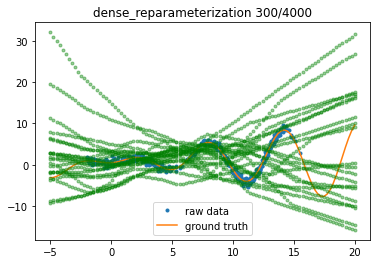

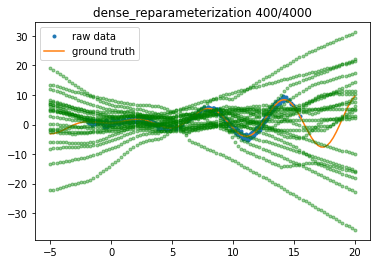

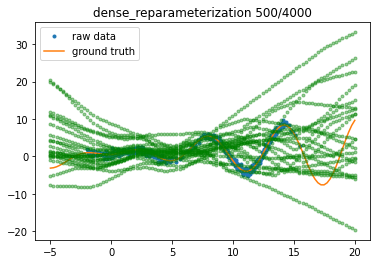

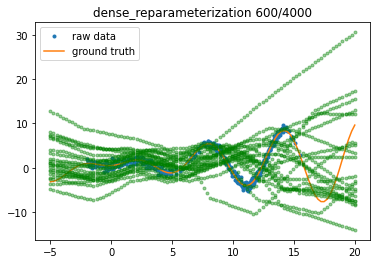

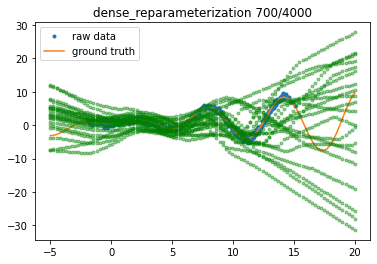

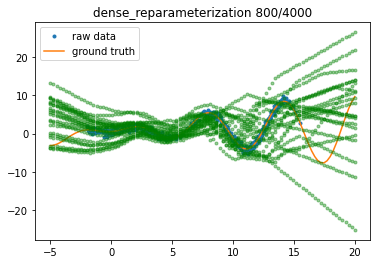

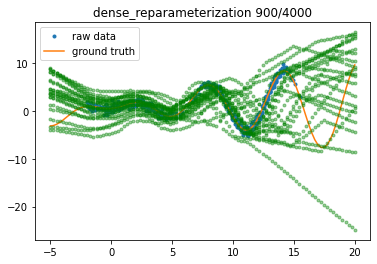

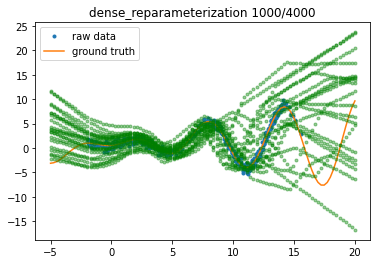

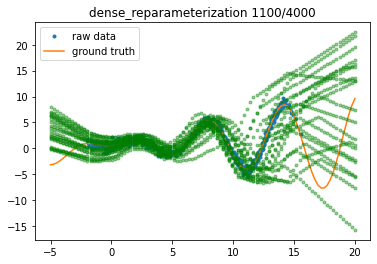

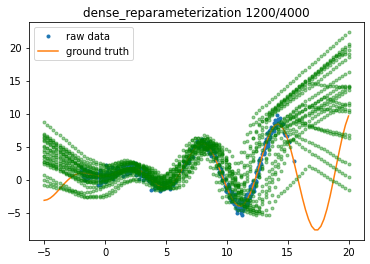

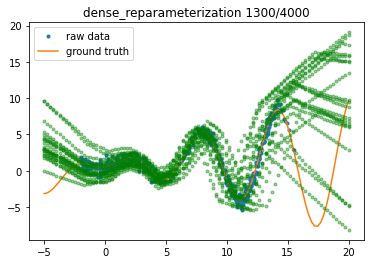

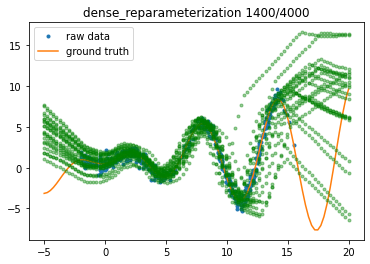

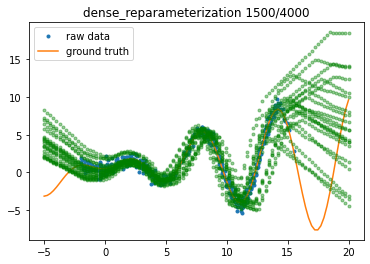

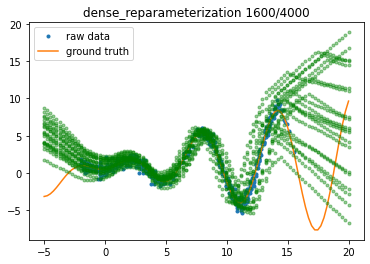

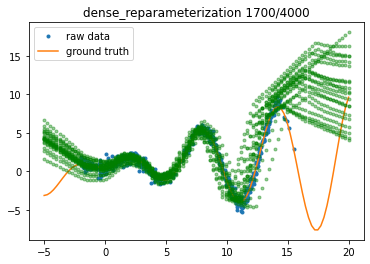

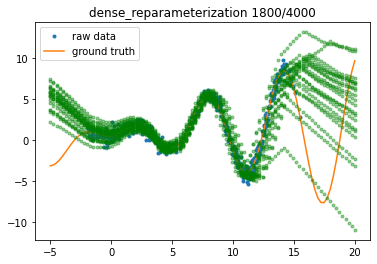

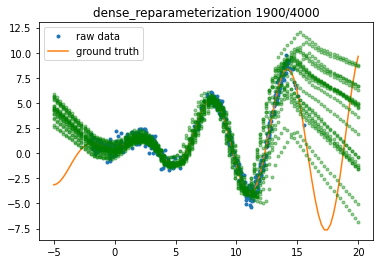

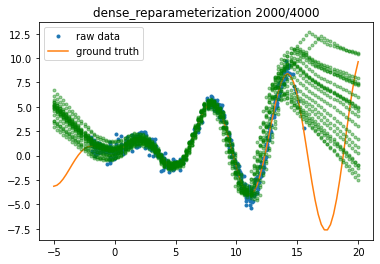

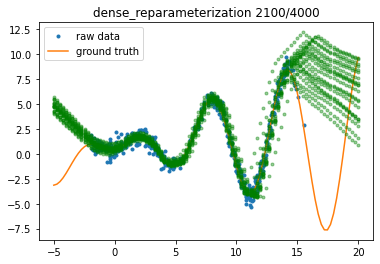

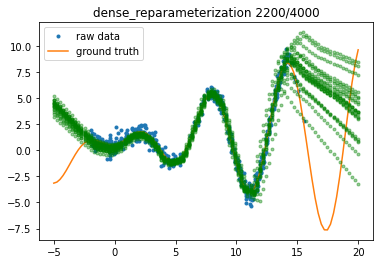

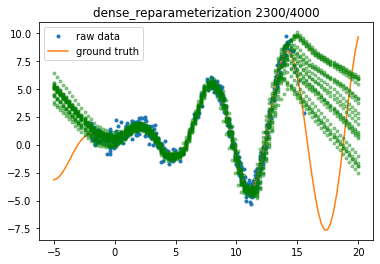

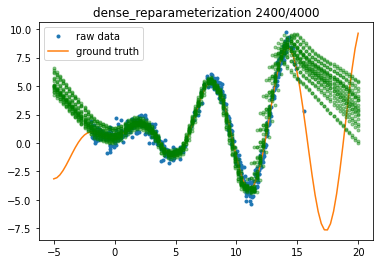

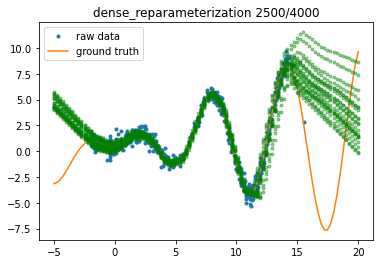

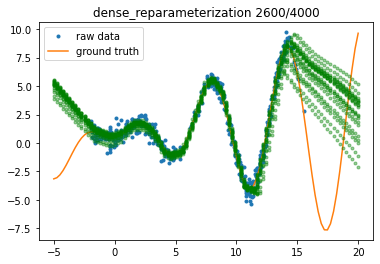

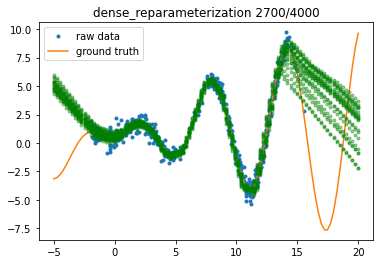

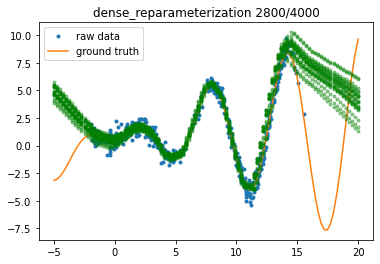

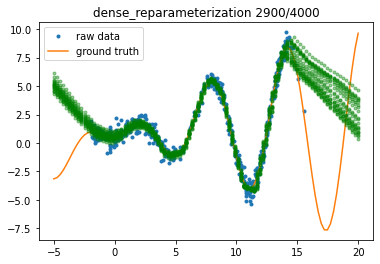

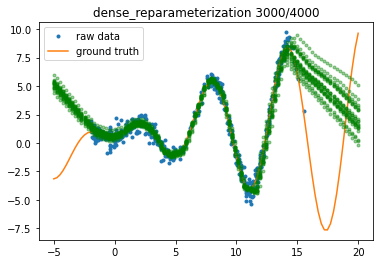

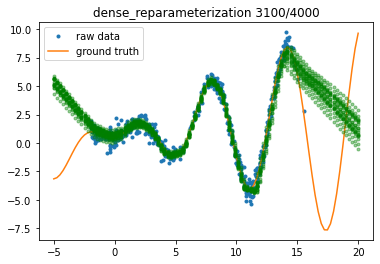

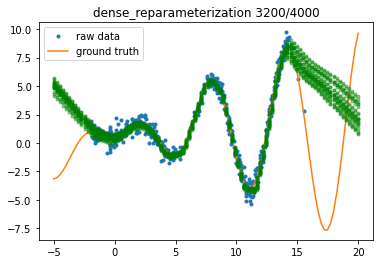

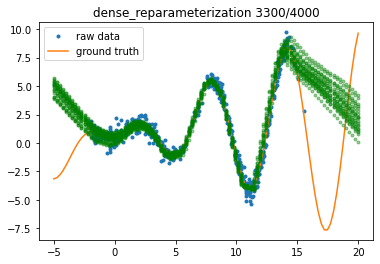

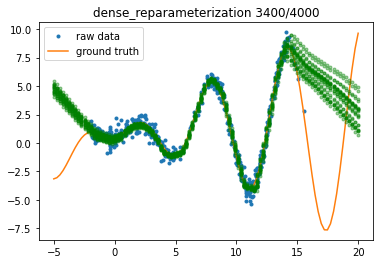

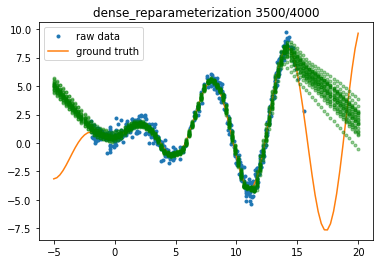

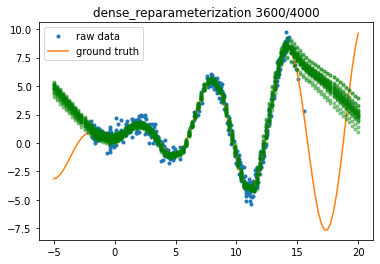

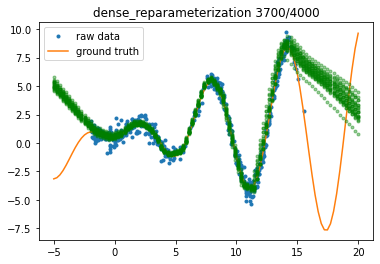

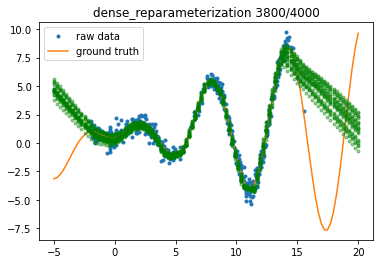

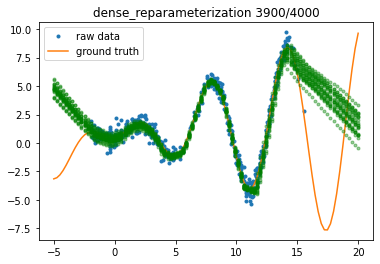

In [14]:
writer = tf.summary.create_file_writer(logdir=f"logs/{datetime.datetime.now().strftime(f'%Y%m%d-%H%M%S-{m.layers[0].name}')}")
for m in [m]:
    opt = tf.keras.optimizers.Adam()
 
    N = data_x.shape[0]
    M = 64
    K = int(N/M)
    rng = np.random.default_rng()
    for i in tqdm(range(epochs)):
        rng.shuffle(data_i)
        for k in range(K):
            _i_ = data_i[M*k:M*(k+1)]
            _n_ = _i_.shape[0]
            grad_vars = opt._compute_gradients(loss(m,data_x[_i_].reshape(-1,1),data_y[_i_].reshape(-1,1),i,_n_,writer),m.trainable_variables)
            grad_vars = [(tf.where(tf.math.is_finite(g),g,tf.zeros_like(g))*N,v) for g,v in grad_vars]
            opt.apply_gradients(grad_vars)
 
        if i % 100 == 0:
            plt.plot(data_x,data_y,linestyle="",marker=".",label="raw data")
            plt.plot(x_,ground_truth(x_),label="ground truth")
 
            for _ in range(20):
                plt.plot(x_,m(x_),color="green",alpha=0.4,marker=".",linestyle="")
 
            plt.title(m.layers[0].name + f" {i}/{epochs}")
            plt.legend()
            plt.show()

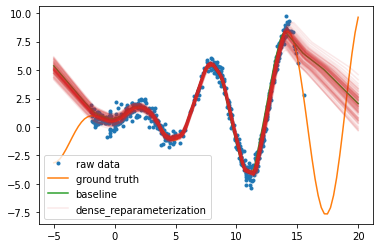

In [19]:
plt.plot(data_x,data_y,marker=".",linestyle="",label="raw data")
plt.plot(x_,ground_truth(x_),label="ground truth")
plt.plot(x_,m0(x_),label="baseline")

for _ in range(100):
    plt.plot(x_,m(x_),color="tab:red",alpha=0.1)
else:
    plt.plot(x_,m(x_),color="tab:red",label=m.layers[0].name,alpha=0.1)

plt.legend()